# Part 3: The Vote - Activation Functions 

## The Brain's Decision Committee - Chapter 3

---

**Previously:** In Part 2, our first committee member learned to gather evidence (inputs), weigh it (weights), add their personal threshold (bias), and calculate a score (weighted sum). But a score isn't a decision.

**Today's Mission:** Our committee member needs to cast their **vote**. The score tells them how convinced they are, but now they need to turn that into an actual decision. There are several ways to vote—and choosing the right one matters.

---

###  What You'll Learn

By the end of this notebook, you will understand:

1. **Why activation functions are necessary** - Linear isn't enough!
2. **Step Function** - The simplest "yes or no" vote
3. **Sigmoid** - A smooth probability between 0 and 1  
4. **Tanh** - A centered vote from -1 to +1
5. **ReLU** - The modern workhorse (and its quirks)
6. **Softmax** - For multi-class decisions
7. **How to choose** the right activation for your problem

---

###  Prerequisites

Make sure you've completed:
-  **Part 0:** Welcome & Introduction (`neural_network_fundamentals.ipynb`)
-  **Part 1:** Matrices - The Language of the Brain (`neural_network_fundamentals.ipynb`)
-  **Part 2:** The First Committee Member (`part_2_single_neuron.ipynb`)


---

## 🔧 Setup: Import Dependencies

Let's import our tools and set up our environment. We'll also recreate our V/H line examples from previous notebooks.


In [4]:
# =============================================================================
# PART 3: ACTIVATION FUNCTIONS - SETUP
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display, clear_output, HTML

# Try to import ipywidgets for interactive features
try:
    import ipywidgets as widgets
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False
    print("  ipywidgets not installed. Interactive features will be limited.")
    print("   Install with: pip install ipywidgets")

# Set up matplotlib style
style_options = ['seaborn-v0_8-whitegrid', 'seaborn-whitegrid', 'ggplot', 'default']
for style in style_options:
    try:
        plt.style.use(style)
        break
    except OSError:
        continue

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
np.random.seed(42)

# =============================================================================
# RECREATE OUR V/H LINE EXAMPLES (from previous notebooks)
# =============================================================================

# Our canonical vertical and horizontal lines
vertical_line = np.array([
    [0, 1, 0],
    [0, 1, 0],
    [0, 1, 0]
])

horizontal_line = np.array([
    [0, 0, 0],
    [1, 1, 1],
    [0, 0, 0]
])

# Flattened versions for neuron input
vertical_flat = vertical_line.flatten()
horizontal_flat = horizontal_line.flatten()

# =============================================================================
# RECREATE OUR SIMPLE NEURON CLASS (from Part 2)
# =============================================================================

class SimpleNeuron:
    """
    A simple neuron that computes weighted sum + bias (no activation yet).
    From Part 2: The First Committee Member.
    """
    def __init__(self, n_inputs):
        """Initialize neuron with random weights and bias."""
        self.weights = np.random.randn(n_inputs) * 0.5
        self.bias = np.random.randn() * 0.1
        self.n_inputs = n_inputs
    
    def forward(self, x):
        """Compute the weighted sum (pre-activation value)."""
        x = np.array(x).flatten()
        return np.dot(self.weights, x) + self.bias
    
    def set_weights(self, weights, bias=None):
        """Manually set weights and bias."""
        self.weights = np.array(weights).flatten()
        if bias is not None:
            self.bias = bias

print(" All libraries imported successfully!")
print(f"   NumPy version: {np.__version__}")
print(f"   Matplotlib version: {plt.matplotlib.__version__}")
if WIDGETS_AVAILABLE:
    print(f"   IPyWidgets available: Yes")
else:
    print(f"   IPyWidgets available: No (interactive labs won't work)")
print("\n Welcome to Part 3: Activation Functions!")
print("   Time to learn how to cast our vote.")


 All libraries imported successfully!
   NumPy version: 2.3.1
   Matplotlib version: 3.10.5
   IPyWidgets available: Yes

 Welcome to Part 3: Activation Functions!
   Time to learn how to cast our vote.


---

## 3.1 Why Activate? The Problem with Pure Mathematics

### First, What IS an Activation Function?

An **activation function** is a mathematical function that transforms the neuron's raw score into a useful output.

| Term | Meaning | Example |
|------|---------|---------|
| **Input to activation** | The weighted sum `z = w·x + b` | z = 2.3 |
| **Activation function** | A formula that transforms z | sigmoid(z) |
| **Output of activation** | The transformed value | 0.91 |

Think of it as a "translator" - it takes the neuron's raw calculation and converts it into something meaningful.

###  Committee Analogy

Our committee member has done the math:
- Gathered all the evidence (inputs)
- Multiplied by how much each piece matters (weights)
- Added their personal threshold (bias)
- Got a final **score**

**But here's the problem:** That score could be *anything*. It might be -37.5, or 102.3, or 0.0001.

**A vote needs to be meaningful.** When you ask "Is this a vertical line?", you don't want to hear "-14.7". You want to hear:
- "Yes" or "No" (binary)
- "I'm 85% confident it's vertical" (probability)
- "On a scale of -1 to 1, I'd say 0.7 toward vertical" (centered scale)

**Activation functions transform raw scores into meaningful decisions.**

---

### The Deeper Problem: Linear Functions Aren't Enough

#### What Does "Linear" Mean?

A **linear function** is one where the output changes proportionally with the input - draw it on a graph and you get a straight line.

```
Linear:      y = 3x + 2     (always a straight line)
Non-linear:  y = x²         (a curve)
Non-linear:  y = sigmoid(x) (an S-curve)
```

**Why does this matter?** Many real-world patterns are NOT straight lines!

There's a mathematical reason why activation functions are essential, beyond just making outputs meaningful.

**Without activation:** If our neuron just outputs the weighted sum, it's a **linear function**:

$$z = w_1x_1 + w_2x_2 + ... + w_nx_n + b$$

The problem? **Stacking linear functions gives you another linear function!**

If we chain two neurons without activation:
- Neuron 1: $z_1 = W_1 \cdot x + b_1$
- Neuron 2: $z_2 = W_2 \cdot z_1 + b_2 = W_2 \cdot (W_1 \cdot x + b_1) + b_2$

This simplifies to: $z_2 = (W_2 \cdot W_1) \cdot x + (W_2 \cdot b_1 + b_2)$

**That's just another linear function!** No matter how many layers we stack, we're still just drawing straight lines. But many real problems need **curved** decision boundaries.

Let's visualize this:


C:\Users\asggm\AppData\Local\Temp\ipykernel_32624\2968015137.py:63: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\asggm\AppData\Local\Temp\ipykernel_32624\2968015137.py:63: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()


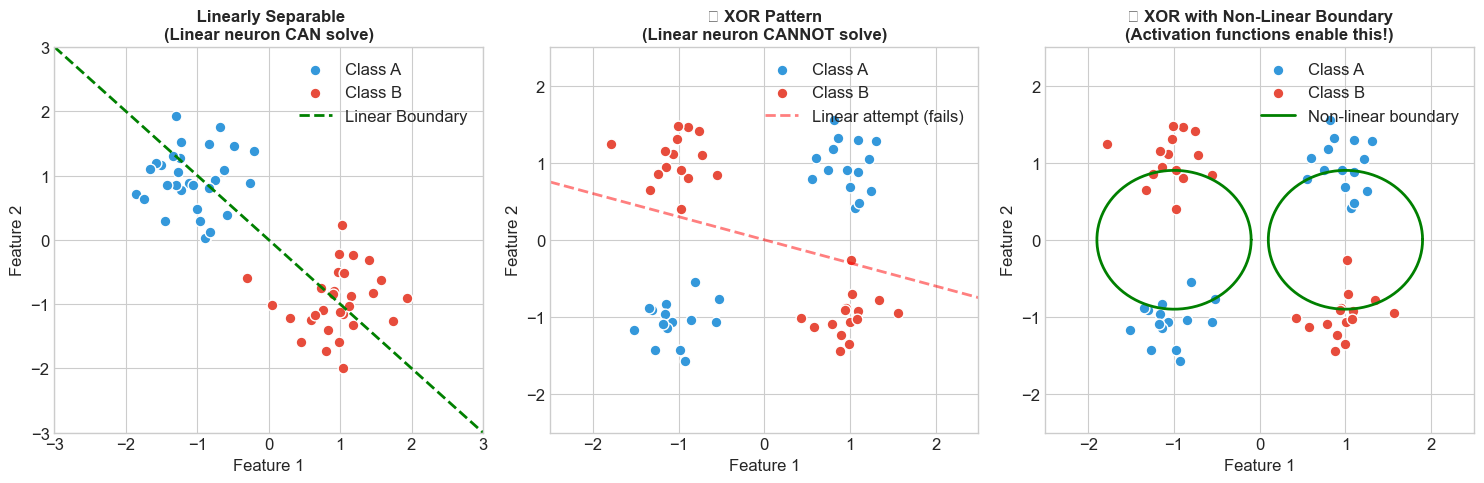


 Key Insight:
   Without activation functions, neural networks can only draw straight lines.
   With activation functions, they can draw curves, circles, and complex shapes!
   This is what makes deep learning powerful.


In [6]:
# =============================================================================
# VISUALIZE: Linear vs Non-Linear Decision Boundaries
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Problem 1: Linearly Separable (can solve with linear)
ax1 = axes[0]
np.random.seed(42)
# Class A: upper left
class_a = np.random.randn(30, 2) * 0.5 + [-1, 1]
# Class B: lower right
class_b = np.random.randn(30, 2) * 0.5 + [1, -1]
ax1.scatter(class_a[:, 0], class_a[:, 1], c='#3498db', s=60, label='Class A', edgecolors='white')
ax1.scatter(class_b[:, 0], class_b[:, 1], c='#e74c3c', s=60, label='Class B', edgecolors='white')
# Linear boundary
x_line = np.linspace(-3, 3, 100)
ax1.plot(x_line, -x_line, 'g--', linewidth=2, label='Linear Boundary')
ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)
ax1.set_title(' Linearly Separable\n(Linear neuron CAN solve)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

# Problem 2: XOR Pattern (cannot solve with linear)
ax2 = axes[1]
# XOR: opposite corners are same class
xor_class_a = np.array([[-1, -1], [1, 1]])  # Diagonal pair 1
xor_class_b = np.array([[-1, 1], [1, -1]])   # Diagonal pair 2
# Add some noise around each point
np.random.seed(42)
xor_a_noisy = np.vstack([xor_class_a[0] + np.random.randn(15, 2)*0.3,
                          xor_class_a[1] + np.random.randn(15, 2)*0.3])
xor_b_noisy = np.vstack([xor_class_b[0] + np.random.randn(15, 2)*0.3,
                          xor_class_b[1] + np.random.randn(15, 2)*0.3])
ax2.scatter(xor_a_noisy[:, 0], xor_a_noisy[:, 1], c='#3498db', s=60, label='Class A', edgecolors='white')
ax2.scatter(xor_b_noisy[:, 0], xor_b_noisy[:, 1], c='#e74c3c', s=60, label='Class B', edgecolors='white')
# Try to draw a line - it fails!
ax2.plot(x_line, -x_line * 0.3, 'r--', linewidth=2, alpha=0.5, label='Linear attempt (fails)')
ax2.set_xlim(-2.5, 2.5)
ax2.set_ylim(-2.5, 2.5)
ax2.set_title('❌ XOR Pattern\n(Linear neuron CANNOT solve)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')

# Problem 3: XOR with non-linear boundary
ax3 = axes[2]
ax3.scatter(xor_a_noisy[:, 0], xor_a_noisy[:, 1], c='#3498db', s=60, label='Class A', edgecolors='white')
ax3.scatter(xor_b_noisy[:, 0], xor_b_noisy[:, 1], c='#e74c3c', s=60, label='Class B', edgecolors='white')
# Draw non-linear boundary (curves)
theta = np.linspace(0, 2*np.pi, 100)
ax3.plot(0.9*np.cos(theta) - 1, 0.9*np.sin(theta), 'g-', linewidth=2)
ax3.plot(0.9*np.cos(theta) + 1, 0.9*np.sin(theta), 'g-', linewidth=2, label='Non-linear boundary')
ax3.set_xlim(-2.5, 2.5)
ax3.set_ylim(-2.5, 2.5)
ax3.set_title('✅ XOR with Non-Linear Boundary\n(Activation functions enable this!)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.set_xlabel('Feature 1')
ax3.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

print("\n Key Insight:")
print("   Without activation functions, neural networks can only draw straight lines.")
print("   With activation functions, they can draw curves, circles, and complex shapes!")
print("   This is what makes deep learning powerful.")


---

## 3.2 Step Function - The Binary Vote

###  Committee Analogy: "Yes or No, Nothing In Between"

The Step Function is the simplest voting method. It's like a committee member who can only say:
- **"YES"** (vote = 1) if the score is at or above 0
- **"NO"** (vote = 0) if the score is below 0

No hesitation. No "maybe". Just a crisp, decisive vote.

### The Mathematics

$$f(z) = \begin{cases} 1 & \text{if } z \geq 0 \\ 0 & \text{if } z < 0 \end{cases}$$

Where $z$ is the weighted sum (pre-activation value) from our neuron.

### Historical Context

This was the activation function used in the **original Perceptron** (Rosenblatt, 1958). It's historically significant—the first neural networks used this simple approach.

### Implementation


In [ ]:
# =============================================================================
# STEP FUNCTION: Implementation and Visualization
# =============================================================================

def step_function(z):
    """
    Step activation function.
    Returns 1 if z >= 0, else 0.
    
    Parameters:
        z: input value (weighted sum)
    
    Returns:
        0 or 1
    """
    return np.where(z >= 0, 1, 0)

# Create a range of z values to visualize
z_values = np.linspace(-5, 5, 1000)
step_output = step_function(z_values)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: The step function curve
ax1 = axes[0]
ax1.plot(z_values, step_output, 'b-', linewidth=3, label='Step Function')
ax1.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax1.scatter([0], [1], color='blue', s=100, zorder=5)  # Point at z=0
ax1.set_xlabel('z (weighted sum)', fontsize=12)
ax1.set_ylabel('f(z) (output)', fontsize=12)
ax1.set_title('Step Function: The Binary Vote', fontsize=14, fontweight='bold')
ax1.set_ylim(-0.2, 1.3)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Annotate
ax1.annotate('If z ≥ 0 → Output 1', xy=(2, 1), fontsize=11, color='green')
ax1.annotate('If z < 0 → Output 0', xy=(-4.5, 0.1), fontsize=11, color='red')
ax1.annotate('Decision boundary\nat z = 0', xy=(0.2, 0.5), fontsize=10, color='gray')

# Plot 2: Show how it works with example values
ax2 = axes[1]
example_z = np.array([-2.5, -1.0, -0.1, 0, 0.1, 1.0, 2.5])
example_output = step_function(example_z)

colors = ['#e74c3c' if o == 0 else '#27ae60' for o in example_output]
bars = ax2.bar(range(len(example_z)), example_output, color=colors, edgecolor='white', linewidth=2)
ax2.set_xticks(range(len(example_z)))
ax2.set_xticklabels([f'z={z:.1f}' for z in example_z], rotation=45)
ax2.set_ylabel('Output', fontsize=12)
ax2.set_title('Step Function Examples', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1.3)

# Add value labels on bars
for i, (z, out) in enumerate(zip(example_z, example_output)):
    ax2.annotate(f'{int(out)}', xy=(i, out + 0.05), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Test with our neuron
print("\n🔬 Testing Step Function with our V/H Detector:")
print("=" * 50)

# Create a neuron with hand-designed vertical detector weights
vertical_detector = SimpleNeuron(9)
detector_weights = np.array([
    -1, +2, -1,  # Top row: high weight in middle
    -1, +2, -1,  # Middle row: high weight in middle  
    -1, +2, -1   # Bottom row: high weight in middle
]).astype(float) * 0.5
vertical_detector.set_weights(detector_weights, bias=-1.0)

# Get raw scores
v_score = vertical_detector.forward(vertical_flat)
h_score = vertical_detector.forward(horizontal_flat)

print(f"\nVertical Line:")
print(f"  Raw score (z):     {v_score:.3f}")
print(f"  Step activation:   {step_function(v_score)} {'✓ Correct (Vertical)' if step_function(v_score) == 1 else '✗ Wrong'}")

print(f"\nHorizontal Line:")
print(f"  Raw score (z):     {h_score:.3f}")
print(f"  Step activation:   {step_function(h_score)} {'✓ Correct (Not Vertical)' if step_function(h_score) == 0 else '✗ Wrong'}")


### ⚠️ The Problem with Step Functions

**The step function has a critical flaw:** It's not differentiable at z = 0, and the gradient is 0 everywhere else.

#### What Does "Differentiable" Mean?

A function is **differentiable** if you can calculate its slope (how steep it is) at every point.

| Function | At z = 0.5 | Differentiable? |
|----------|------------|-----------------|
| Sigmoid | Smooth curve, slope = 0.24 |  Yes |
| Step | Flat (slope = 0) |  No (at z=0 it jumps!) |

**The step function has a "jump"** - it goes from 0 to 1 instantly at z = 0. There's no smooth slope at that point. It's like asking "what's the steepness of a cliff edge?" - the question doesn't have a good answer.

#### Why Does Differentiability Matter for Learning?

Neural networks learn by:
1. Making a prediction
2. Measuring how wrong it is (loss)
3. Using the **derivative** to figure out which direction to adjust weights
4. Adjusting weights slightly in that direction

If the derivative is always 0 (flat) or undefined (jump), the network has **no signal** to tell it how to improve. It's like trying to find the bottom of a valley while blindfolded - you need to feel the slope to know which way is down!

**Why does this matter?** In Part 5, we'll learn that neural networks learn by using **gradients** to figure out how to adjust weights. If the gradient is always 0, the network can't learn!

| Pros | Cons |
|------|------|
| ✅ Simple to understand | ❌ Not differentiable (can't use gradient descent) |
| ✅ Clear binary output | ❌ No gradient signal for learning |
| ✅ Historically important | ❌ All-or-nothing (loses information) |

**The step function is great for understanding, but modern networks need smoother alternatives.**

---

## 3.3 Sigmoid - The Confidence Vote

###  Committee Analogy: "I'm 85% Sure It's Vertical"

The Sigmoid function is like a committee member who expresses **confidence levels**:
- Instead of "YES" or "NO", they say "I'm 85% confident it's vertical"
- Output is always between 0 and 1
- Can be interpreted as a **probability**

This is much more nuanced than the step function!

### The Mathematics

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

Where:
- $z$ is the weighted sum (pre-activation value)
- $e$ is Euler's number (≈ 2.718)
- $\sigma(z)$ smoothly maps any input to the range (0, 1)

### What is Euler's Number (e)?

You'll see **e ≈ 2.71828** in many formulas. It's a special mathematical constant (like π = 3.14159).

**Why e?** When you raise e to a power, you get a curve that:
- Grows smoothly and never stops
- Has a special property: its slope at any point equals its value at that point!

**For sigmoid:** The `e^(-z)` term creates the smooth S-curve:
- When z is very negative: `e^(-z)` is huge → output ≈ 0
- When z is very positive: `e^(-z)` is tiny → output ≈ 1
- When z = 0: `e^0 = 1` → output = 0.5

Don't worry about memorizing e - just know it creates smooth curves!

### Key Properties

| Input (z) | Output σ(z) | Interpretation |
|-----------|-------------|----------------|
| Very negative (-5) | ≈ 0.007 | "Almost certain it's NOT vertical" |
| Negative (-2) | ≈ 0.12 | "Probably not vertical" |
| Zero (0) | = 0.5 | "Completely uncertain" |
| Positive (+2) | ≈ 0.88 | "Probably vertical" |
| Very positive (+5) | ≈ 0.993 | "Almost certain it's vertical" |

### Implementation


In [ ]:
# =============================================================================
# SIGMOID FUNCTION: Implementation and Visualization
# =============================================================================

def sigmoid(z):
    """
    Sigmoid activation function.
    Maps any real number to range (0, 1).
    
    Parameters:
        z: input value (weighted sum)
    
    Returns:
        Value between 0 and 1 (can be interpreted as probability)
    """
    return 1 / (1 + np.exp(-z))

# Create visualization
z_values = np.linspace(-6, 6, 1000)
sigmoid_output = sigmoid(z_values)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Sigmoid curve with annotations
ax1 = axes[0]
ax1.plot(z_values, sigmoid_output, 'b-', linewidth=3, label='Sigmoid σ(z)')
ax1.plot(z_values, step_function(z_values), 'r--', linewidth=2, alpha=0.5, label='Step (comparison)')
ax1.axhline(y=0.5, color='gray', linestyle=':', alpha=0.7)
ax1.axvline(x=0, color='gray', linestyle=':', alpha=0.7)
ax1.set_xlabel('z (weighted sum)', fontsize=12)
ax1.set_ylabel('σ(z) (output)', fontsize=12)
ax1.set_title('Sigmoid: The Confidence Vote', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.1, 1.1)

# Add annotations
ax1.annotate('Approaches 1\n(high confidence)', xy=(4, 0.95), fontsize=10, color='green',
            ha='center')
ax1.annotate('Approaches 0\n(low confidence)', xy=(-4, 0.05), fontsize=10, color='red',
            ha='center')
ax1.annotate('50% uncertainty\nat z = 0', xy=(0.5, 0.5), fontsize=10, color='gray')

# Plot 2: Sigmoid vs Step comparison
ax2 = axes[1]
example_z = np.array([-3, -2, -1, -0.5, 0, 0.5, 1, 2, 3])
sig_vals = sigmoid(example_z)
step_vals = step_function(example_z)

x = np.arange(len(example_z))
width = 0.35

bars1 = ax2.bar(x - width/2, sig_vals, width, label='Sigmoid', color='#3498db', edgecolor='white')
bars2 = ax2.bar(x + width/2, step_vals, width, label='Step', color='#e74c3c', alpha=0.6, edgecolor='white')

ax2.set_xlabel('z value', fontsize=12)
ax2.set_ylabel('Output', fontsize=12)
ax2.set_title('Sigmoid vs Step: Notice the Smoothness', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f'{z:.1f}' for z in example_z])
ax2.legend()
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Test with our V/H detector
print("\n🔬 Testing Sigmoid with our V/H Detector:")
print("=" * 50)

print(f"\nVertical Line:")
print(f"  Raw score (z):      {v_score:.3f}")
print(f"  Step output:        {step_function(v_score)}")
print(f"  Sigmoid output:     {sigmoid(v_score):.4f} = {sigmoid(v_score)*100:.1f}% confidence")

print(f"\nHorizontal Line:")
print(f"  Raw score (z):      {h_score:.3f}")
print(f"  Step output:        {step_function(h_score)}")
print(f"  Sigmoid output:     {sigmoid(h_score):.4f} = {sigmoid(h_score)*100:.1f}% confidence")

print("\n💡 Notice: Sigmoid gives us nuanced confidence levels, not just 0 or 1!")


### The Sigmoid Derivative (Why It Matters for Learning)

#### First, What IS a Derivative?

The **derivative** tells you the **slope** (steepness) of a curve at any point.

| Slope | What It Means | Learning Impact |
|-------|---------------|-----------------|
| Steep (large derivative) | Output changes quickly when input changes | Strong learning signal |
| Flat (small derivative) | Output barely changes when input changes | Weak learning signal |
| Zero | Output doesn't change at all | NO learning signal! |

**Simple Example:** If you're walking up a hill:
- Steep section: Each step moves you a lot higher → large derivative
- Flat section: Each step barely changes your height → small derivative

#### Why Derivatives Matter for Training

Neural networks learn by asking: "If I change this weight slightly, how does the output change?"

The derivative answers this question! If the derivative is:
- **Large:** Small weight change → big output change → we know which direction helps
- **Small:** Small weight change → tiny output change → hard to tell which direction helps
- **Zero:** Weight change → no output change → we're stuck!

#### The Beautiful Sigmoid Derivative Formula

A beautiful property of sigmoid: its derivative has a simple form!

$$\frac{d\sigma}{dz} = \sigma(z) \cdot (1 - \sigma(z))$$

This elegant formula means:
- If we know the output, we can easily compute the gradient
- The gradient is highest around z = 0 (where the function is steepest)
- The gradient approaches 0 as z gets very large or very small

### ⚠️ The Vanishing Gradient Problem

**This is important:** Look at the derivative plot below. Notice how the gradient is nearly 0 for large positive or negative z values.

When the gradient is nearly 0, learning almost stops! The network can't figure out which direction to adjust weights.

This causes the **vanishing gradient problem** in deep networks—a topic we'll explore deeply in Part 8. For now, just know that sigmoid can make deep networks hard to train.


In [ ]:
# =============================================================================
# SIGMOID DERIVATIVE: Visualization
# =============================================================================

def sigmoid_derivative(z):
    """
    Derivative of sigmoid function.
    σ'(z) = σ(z) * (1 - σ(z))
    """
    s = sigmoid(z)
    return s * (1 - s)

# Visualize sigmoid and its derivative
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

z_values = np.linspace(-6, 6, 1000)

# Plot sigmoid and derivative together
ax1 = axes[0]
ax1.plot(z_values, sigmoid(z_values), 'b-', linewidth=3, label='Sigmoid σ(z)')
ax1.plot(z_values, sigmoid_derivative(z_values), 'r-', linewidth=3, label="Derivative σ'(z)")
ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax1.axhline(y=0.25, color='gray', linestyle=':', alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('z (weighted sum)', fontsize=12)
ax1.set_ylabel('Output', fontsize=12)
ax1.set_title('Sigmoid and Its Derivative', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Annotate
ax1.annotate('Max gradient = 0.25\nat z = 0', xy=(0.5, 0.25), fontsize=10, color='red')

# Plot: Show where gradient vanishes
ax2 = axes[1]
ax2.fill_between(z_values, sigmoid_derivative(z_values), alpha=0.3, color='red')
ax2.plot(z_values, sigmoid_derivative(z_values), 'r-', linewidth=3, label="Derivative σ'(z)")
ax2.axhline(y=0.01, color='orange', linestyle='--', linewidth=2, label='Vanishing threshold')

# Highlight vanishing regions
ax2.axvspan(-6, -4, alpha=0.2, color='gray', label='Vanishing gradient zone')
ax2.axvspan(4, 6, alpha=0.2, color='gray')

ax2.set_xlabel('z (weighted sum)', fontsize=12)
ax2.set_ylabel('Gradient magnitude', fontsize=12)
ax2.set_title('⚠️ The Vanishing Gradient Problem', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.02, 0.3)

plt.tight_layout()
plt.show()

print("\n⚠️ Key Warning about Sigmoid:")
print("   The maximum gradient is only 0.25 (at z = 0)")
print("   In deep networks, gradients multiply through layers:")
print("   0.25 × 0.25 × 0.25 = 0.016 (after just 3 layers!)")
print("   This makes deep networks very hard to train with sigmoid.")


---

## 3.4 Tanh - The Centered Vote

### 🧠 Committee Analogy: "From Strongly Against to Strongly For"

Tanh (hyperbolic tangent) is like a committee member who can express the **full spectrum of opinion**:
- **-1:** "I strongly believe this is NOT vertical"
- **0:** "I'm completely neutral / unsure"
- **+1:** "I strongly believe this IS vertical"

The key difference from sigmoid: **zero means neutral**, not uncertain.

### The Mathematics

$$\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$$

Or equivalently:
$$\tanh(z) = 2\sigma(2z) - 1$$

(It's just a rescaled, shifted sigmoid!)

### What Does "Zero-Centered" Mean?

**Zero-centered** means the average output is around 0, with equal spread in both directions.

| Activation | Output Range | Center Point | Zero-Centered? |
|------------|-------------|--------------|----------------|
| Sigmoid | (0, 1) | 0.5 | ❌ No (always positive) |
| Tanh | (-1, 1) | 0 | ✅ Yes |

**Visualize it:**
```
Sigmoid outputs:    0 =====[0.5]=====▓▓▓▓▓ 1     (all positive)
Tanh outputs:      -1 ▓▓▓▓▓[0.0]▓▓▓▓▓ +1         (balanced around 0)
```

### Why Zero-Centered Matters for Learning

When training, the gradient is calculated as `(output) × (some error term)`.

| With Sigmoid | With Tanh |
|--------------|-----------|
| Output always > 0 | Output can be + or - |
| Gradient always same sign | Gradient can be + or - |
| Weights zig-zag | Weights can go directly |

**The Result:** With sigmoid, all weight updates push in the same direction, then overcorrect, then push back... creating inefficient zig-zag learning. Tanh avoids this!

**Zero-centered outputs** are helpful for training because:
- Negative inputs can push weights in one direction
- Positive inputs can push weights in the other direction
- This creates a balanced learning signal

With sigmoid (outputs 0 to 1), all outputs are positive, which can cause slower, zig-zagging learning.

### Implementation


In [ ]:
# =============================================================================
# TANH FUNCTION: Implementation and Visualization
# =============================================================================

def tanh(z):
    """
    Hyperbolic tangent activation function.
    Maps any real number to range (-1, 1).
    
    Parameters:
        z: input value (weighted sum)
    
    Returns:
        Value between -1 and 1 (zero-centered)
    """
    return np.tanh(z)  # NumPy has built-in tanh

# Or implementing from scratch:
def tanh_manual(z):
    """Manual implementation of tanh."""
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

# Visualize
z_values = np.linspace(-5, 5, 1000)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Tanh curve
ax1 = axes[0]
ax1.plot(z_values, tanh(z_values), 'purple', linewidth=3, label='tanh(z)')
ax1.plot(z_values, sigmoid(z_values), 'b--', linewidth=2, alpha=0.6, label='sigmoid (comparison)')
ax1.axhline(y=0, color='gray', linestyle='-', linewidth=1)
ax1.axhline(y=-1, color='gray', linestyle=':', alpha=0.5)
ax1.axhline(y=1, color='gray', linestyle=':', alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('z (weighted sum)', fontsize=12)
ax1.set_ylabel('tanh(z)', fontsize=12)
ax1.set_title('Tanh: The Centered Vote', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-1.3, 1.3)

# Annotate
ax1.annotate('+1 (strongly for)', xy=(3.5, 1.05), fontsize=10, color='green')
ax1.annotate('-1 (strongly against)', xy=(2.5, -1.15), fontsize=10, color='red')
ax1.annotate('0 (neutral) at z=0', xy=(0.3, 0.1), fontsize=10, color='gray')

# Plot 2: Compare sigmoid vs tanh
ax2 = axes[1]
ax2.fill_between(z_values, 0, sigmoid(z_values), alpha=0.3, color='blue', label='Sigmoid range (0, 1)')
ax2.fill_between(z_values, 0, tanh(z_values), alpha=0.3, color='purple', label='Tanh range (-1, 1)')
ax2.plot(z_values, sigmoid(z_values), 'b-', linewidth=2)
ax2.plot(z_values, tanh(z_values), 'purple', linewidth=2)
ax2.axhline(y=0, color='black', linewidth=1)
ax2.set_xlabel('z (weighted sum)', fontsize=12)
ax2.set_ylabel('Output', fontsize=12)
ax2.set_title('Sigmoid vs Tanh: Notice Tanh is Zero-Centered', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test with our V/H detector
print("\n🔬 Testing Tanh with our V/H Detector:")
print("=" * 50)

print(f"\nVertical Line:")
print(f"  Raw score (z):    {v_score:.3f}")
print(f"  Sigmoid output:   {sigmoid(v_score):.4f} (range 0-1)")
print(f"  Tanh output:      {tanh(v_score):.4f} (range -1 to +1)")

print(f"\nHorizontal Line:")
print(f"  Raw score (z):    {h_score:.3f}")
print(f"  Sigmoid output:   {sigmoid(h_score):.4f}")
print(f"  Tanh output:      {tanh(h_score):.4f}")

print("\n💡 Notice: Tanh can output negative values, expressing disagreement!")


---

## 3.5 ReLU - The Modern Workhorse

### 🧠 Committee Analogy: "If Not Convinced, Stay Silent"

**ReLU** (Rectified Linear Unit) is the most popular activation function in modern deep learning. It's beautifully simple:

- If the weighted sum is **negative**: Output **0** (stay silent)
- If the weighted sum is **positive**: Output the **raw score** (speak with that intensity)

It's like a committee member who only speaks up when they're convinced. If unconvinced (z < 0), they simply abstain.

### The Name "Rectified Linear Unit"

Let's break down this intimidating name:

| Term | Meaning |
|------|---------|
| **Rectified** | "Fixed" or "corrected" - negative values are "fixed" to 0 |
| **Linear** | For positive values, output = input (a straight line) |
| **Unit** | A single neuron or activation function |

So ReLU just means "a neuron that passes positive values through and blocks negative ones."

### The Mathematics

$$f(z) = \max(0, z) = \begin{cases} z & \text{if } z > 0 \\ 0 & \text{if } z \leq 0 \end{cases}$$

### Why ReLU Dominates Modern Deep Learning

| Advantage | Explanation |
|-----------|-------------|
| **Fast** | Just a comparison: `if z > 0 then z else 0` |
| **Non-saturating** | Gradient is 1 for positive values (no vanishing!) |
| **Sparse activation** | Many neurons output 0, which is computationally efficient |
| **Biologically plausible** | Real neurons have a firing threshold |

### What is "Sparse Activation"?

**Sparse** means "not dense" - most values are zero.

With ReLU, about half of all neurons output exactly 0 (whenever z < 0). This is called **sparse activation**.

| Activation | Typical Output Pattern | Sparsity |
|------------|----------------------|----------|
| Sigmoid | [0.2, 0.7, 0.4, 0.9, 0.3] | Not sparse (all non-zero) |
| ReLU | [0, 2.1, 0, 0, 1.5] | Sparse (many zeros) |

**Why is sparsity good?**
1. **Efficiency:** Multiplying by 0 is fast (and can be skipped)
2. **Interpretability:** Only "activated" neurons contribute to the decision
3. **Regularization:** Prevents over-reliance on any single neuron

### The Derivative

$$f'(z) = \begin{cases} 1 & \text{if } z > 0 \\ 0 & \text{if } z \leq 0 \end{cases}$$

Notice: The gradient is either **0 or 1**—never the tiny values we saw with sigmoid!

### Implementation


In [ ]:
# =============================================================================
# RELU FUNCTION: Implementation and Visualization
# =============================================================================

def relu(z):
    """
    ReLU (Rectified Linear Unit) activation function.
    Returns max(0, z).
    
    Parameters:
        z: input value (weighted sum)
    
    Returns:
        z if z > 0, else 0
    """
    return np.maximum(0, z)

def relu_derivative(z):
    """Derivative of ReLU."""
    return np.where(z > 0, 1, 0)

# Visualize
z_values = np.linspace(-5, 5, 1000)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: ReLU curve
ax1 = axes[0]
ax1.plot(z_values, relu(z_values), 'green', linewidth=3, label='ReLU')
ax1.plot(z_values, z_values, 'gray', linestyle='--', alpha=0.5, label='Identity (z)')
ax1.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax1.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('z (weighted sum)', fontsize=12)
ax1.set_ylabel('ReLU(z)', fontsize=12)
ax1.set_title('ReLU: The Modern Standard', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-1, 5)

# Annotate
ax1.annotate('If z > 0: output = z\n(pass through)', xy=(2.5, 2.7), fontsize=10, color='green')
ax1.annotate('If z ≤ 0: output = 0\n(stay silent)', xy=(-4.5, 0.3), fontsize=10, color='red')

# Plot 2: Compare gradients (this is the key!)
ax2 = axes[1]
ax2.plot(z_values, relu_derivative(z_values), 'green', linewidth=3, label="ReLU gradient")
ax2.plot(z_values, sigmoid_derivative(z_values), 'blue', linewidth=2, alpha=0.7, label="Sigmoid gradient")
ax2.axhline(y=1, color='green', linestyle=':', alpha=0.5)
ax2.axhline(y=0.25, color='blue', linestyle=':', alpha=0.5)
ax2.set_xlabel('z (weighted sum)', fontsize=12)
ax2.set_ylabel('Gradient', fontsize=12)
ax2.set_title('Why ReLU Wins: Strong Gradients!', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.1, 1.2)

# Annotate
ax2.annotate('ReLU: gradient = 1\n(no vanishing!)', xy=(2, 1.05), fontsize=10, color='green')
ax2.annotate('Sigmoid: max gradient = 0.25', xy=(-1, 0.3), fontsize=10, color='blue')

# Plot 3: Compare all activations
ax3 = axes[2]
ax3.plot(z_values, relu(z_values), 'green', linewidth=3, label='ReLU')
ax3.plot(z_values, sigmoid(z_values), 'blue', linewidth=2, label='Sigmoid')
ax3.plot(z_values, tanh(z_values), 'purple', linewidth=2, label='Tanh')
ax3.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax3.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax3.set_xlabel('z (weighted sum)', fontsize=12)
ax3.set_ylabel('Output', fontsize=12)
ax3.set_title('ReLU vs Sigmoid vs Tanh', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(-1.5, 5)

plt.tight_layout()
plt.show()

# Test with our V/H detector
print("\n🔬 Testing ReLU with our V/H Detector:")
print("=" * 50)

print(f"\nVertical Line:")
print(f"  Raw score (z):    {v_score:.3f}")
print(f"  ReLU output:      {relu(v_score):.3f}")

print(f"\nHorizontal Line:")
print(f"  Raw score (z):    {h_score:.3f}")
print(f"  ReLU output:      {relu(h_score):.3f}")

print("\n💡 Notice: ReLU outputs 0 for negative scores, actual value for positive!")


### ☠️ The Dead Neuron Problem (Dead ReLU)

ReLU has its own challenge: **dead neurons**.

### 🧠 Committee Analogy: "The Permanently Skeptical Member"

Imagine a committee member who becomes so pessimistic that they always compute a negative weighted sum. With ReLU, they'll output 0 forever. Since the gradient is also 0 when the output is 0, **they can never recover**—no learning signal gets through!

This member is "dead" to the committee. They contribute nothing and can't be revived.

### How Neurons Die

1. **Bad initialization:** If weights start too negative, z might always be < 0
2. **Large learning rate:** A big update might push weights into permanently negative territory
3. **Unlucky data:** Some neurons just never activate for the training data

### The Solution: Leaky ReLU

Instead of outputting 0 for negative inputs, Leaky ReLU outputs a **small negative value**:

$$f(z) = \begin{cases} z & \text{if } z > 0 \\ \alpha z & \text{if } z \leq 0 \end{cases}$$

Where α is a small constant (typically 0.01).

This ensures there's always *some* gradient, so dead neurons can potentially recover.


In [ ]:
# =============================================================================
# DEAD RELU & LEAKY RELU: Visualization
# =============================================================================

def leaky_relu(z, alpha=0.01):
    """
    Leaky ReLU activation function.
    Returns z if z > 0, else alpha * z.
    
    Parameters:
        z: input value (weighted sum)
        alpha: slope for negative values (default 0.01)
    
    Returns:
        z if z > 0, else alpha * z
    """
    return np.where(z > 0, z, alpha * z)

def leaky_relu_derivative(z, alpha=0.01):
    """Derivative of Leaky ReLU."""
    return np.where(z > 0, 1, alpha)

# Visualize ReLU vs Leaky ReLU
z_values = np.linspace(-5, 5, 1000)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: ReLU vs Leaky ReLU
ax1 = axes[0]
ax1.plot(z_values, relu(z_values), 'green', linewidth=3, label='ReLU')
ax1.plot(z_values, leaky_relu(z_values, alpha=0.1), 'orange', linewidth=3, label='Leaky ReLU (α=0.1)')
ax1.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax1.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('z (weighted sum)', fontsize=12)
ax1.set_ylabel('Output', fontsize=12)
ax1.set_title('ReLU vs Leaky ReLU', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-1, 5)

# Annotate the difference
ax1.annotate('ReLU: completely flat\n(no gradient, neuron dead!)', 
            xy=(-3, 0.1), fontsize=10, color='green')
ax1.annotate('Leaky ReLU: small slope\n(gradient exists, can recover)', 
            xy=(-3, -0.8), fontsize=10, color='orange')

# Plot 2: Compare gradients
ax2 = axes[1]
ax2.plot(z_values, relu_derivative(z_values), 'green', linewidth=3, label='ReLU gradient')
ax2.plot(z_values, leaky_relu_derivative(z_values, alpha=0.1), 'orange', linewidth=3, 
         label='Leaky ReLU gradient (α=0.1)')
ax2.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax2.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('z (weighted sum)', fontsize=12)
ax2.set_ylabel('Gradient', fontsize=12)
ax2.set_title('Gradient Comparison: Dead vs Alive', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.1, 1.2)

# Highlight the dead zone
ax2.axvspan(-5, 0, alpha=0.1, color='red')
ax2.annotate('DEAD ZONE (ReLU)\nNo gradient = no learning!', 
            xy=(-2.5, 0.6), fontsize=10, color='red', ha='center')

plt.tight_layout()
plt.show()

# Demonstrate dead neuron scenario
print("\n☠️ Dead Neuron Demonstration:")
print("=" * 50)

# Neuron with very negative weights (simulating a "dead" neuron)
dead_neuron = SimpleNeuron(9)
dead_neuron.set_weights(np.array([-2]*9), bias=-5)  # Always outputs very negative z

print("\nDead neuron (very negative weights):")
for name, img in [("Vertical", vertical_flat), ("Horizontal", horizontal_flat)]:
    z = dead_neuron.forward(img)
    print(f"  {name}: z = {z:.2f}, ReLU output = {relu(z):.2f}, Leaky ReLU = {leaky_relu(z, 0.1):.2f}")

print("\n⚠️ With ReLU: Both outputs are 0 - this neuron is DEAD!")
print("   With Leaky ReLU: Small negative outputs - can still learn!")


---

## 3.6 Softmax - The Committee Consensus (Multi-Class)

### 🧠 Committee Analogy: "All Votes Must Sum to 100%"

So far, our activation functions have been for **binary** decisions (Vertical vs Horizontal). But what if we had **three or more** options?

- Vertical
- Horizontal
- Diagonal

**Softmax** is like a committee voting system where:
- Each option gets a score
- Scores are converted to **probabilities**
- All probabilities must **sum to 1** (100%)

This is **consensus voting** - every option gets a slice of the pie.

### What is a Probability Distribution?

A **probability distribution** is a list of numbers that:
1. Are all between 0 and 1 (0% to 100%)
2. Add up to exactly 1 (100% total)

**Example - Weather Forecast:**
| Outcome | Probability |
|---------|-------------|
| Sunny | 0.60 (60%) |
| Cloudy | 0.30 (30%) |
| Rainy | 0.10 (10%) |
| **Total** | **1.00 (100%)** |

This makes sense - one of these outcomes WILL happen, and together they cover all possibilities.

### Why Must Probabilities Sum to 1?

**The practical reason:** In classification, we're asking "which class does this belong to?" The answer must be ONE of the classes - so the confidence in all classes together must be 100%.

**Without softmax (raw scores):**
```
Vertical: 5.0, Horizontal: 3.0, Diagonal: 2.0  (sum = 10, not meaningful!)
```

**With softmax (probabilities):**
```
Vertical: 0.84, Horizontal: 0.11, Diagonal: 0.05  (sum = 1.0 ✓)
```

Now we can say: "84% confident it's Vertical"

### The Mathematics

For a vector of scores $\mathbf{z} = [z_1, z_2, ..., z_n]$:

$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}$$

Each output represents the **probability** of that class.

**In Plain English:** Take `e^(each score)`, then divide by the sum of all `e^(scores)`. This guarantees the outputs sum to 1!

### Key Properties

| Property | Explanation |
|----------|-------------|
| **Outputs sum to 1** | All probabilities add up to exactly 1 |
| **All positive** | Even negative inputs give positive probabilities |
| **Amplifies differences** | Larger scores get proportionally more probability |
| **Used for output layer** | Specifically for multi-class classification |

### Softmax vs Sigmoid: When to Use Which

| Scenario | Use This | Why |
|----------|----------|-----|
| 2 classes (V vs H) | Sigmoid | Single output: P(vertical), P(horizontal) = 1 - P(vertical) |
| 3+ classes (V vs H vs D) | Softmax | Need probabilities for EACH class that sum to 1 |

### Implementation


In [ ]:
# =============================================================================
# SOFTMAX FUNCTION: Implementation and Visualization
# =============================================================================

def softmax(z):
    """
    Softmax activation function for multi-class classification.
    Converts a vector of scores into probabilities that sum to 1.
    
    Parameters:
        z: array of scores (one per class)
    
    Returns:
        Array of probabilities (same shape as z, sum = 1)
    """
    # Subtract max for numerical stability (prevents overflow)
    z_stable = z - np.max(z)
    exp_z = np.exp(z_stable)
    return exp_z / np.sum(exp_z)

# Example: Multi-class classification (Vertical, Horizontal, Diagonal)
# Suppose our network outputs these raw scores:
scores_example1 = np.array([2.0, 1.0, 0.1])  # Prefers class 0 (Vertical)
scores_example2 = np.array([0.1, 2.0, 0.5])  # Prefers class 1 (Horizontal)
scores_example3 = np.array([1.0, 1.0, 1.0])  # Uncertain (equal scores)

# Apply softmax
probs_example1 = softmax(scores_example1)
probs_example2 = softmax(scores_example2)
probs_example3 = softmax(scores_example3)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
class_names = ['Vertical', 'Horizontal', 'Diagonal']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for ax, scores, probs, title in zip(
    axes, 
    [scores_example1, scores_example2, scores_example3],
    [probs_example1, probs_example2, probs_example3],
    ['Confident: Vertical', 'Confident: Horizontal', 'Uncertain']
):
    x = np.arange(len(class_names))
    width = 0.35
    
    # Plot raw scores and probabilities
    bars1 = ax.bar(x - width/2, scores, width, label='Raw scores (z)', color='gray', alpha=0.5)
    bars2 = ax.bar(x + width/2, probs, width, label='Softmax (probabilities)', color=colors)
    
    ax.set_ylabel('Value', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.legend()
    ax.set_ylim(0, max(max(scores), 1.1))
    
    # Add probability labels
    for i, (bar, prob) in enumerate(zip(bars2, probs)):
        ax.annotate(f'{prob:.1%}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                   ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Show the math
print("\n📊 Softmax Examples:")
print("=" * 60)

print("\nExample 1: Raw scores [2.0, 1.0, 0.1]")
print(f"  Softmax output: [{', '.join([f'{p:.3f}' for p in probs_example1])}]")
print(f"  Sum of probabilities: {sum(probs_example1):.3f} ✓")
print(f"  Prediction: {class_names[np.argmax(probs_example1)]} ({probs_example1.max():.1%} confident)")

print("\nExample 2: Raw scores [0.1, 2.0, 0.5]")
print(f"  Softmax output: [{', '.join([f'{p:.3f}' for p in probs_example2])}]")
print(f"  Sum of probabilities: {sum(probs_example2):.3f} ✓")
print(f"  Prediction: {class_names[np.argmax(probs_example2)]} ({probs_example2.max():.1%} confident)")

print("\nExample 3: Equal scores [1.0, 1.0, 1.0]")
print(f"  Softmax output: [{', '.join([f'{p:.3f}' for p in probs_example3])}]")
print(f"  Sum of probabilities: {sum(probs_example3):.3f} ✓")
print(f"  All equal! The network is completely uncertain.")

print("\n💡 Notice: Softmax always outputs valid probabilities that sum to 1!")


---

## 3.7 Activation Comparison - When to Use Which?

### The Complete Picture

Now that we've seen all the major activation functions, let's visualize them together and understand when to use each.

### Quick Reference Table

| Activation | Output Range | Use Case | Pros | Cons |
|------------|-------------|----------|------|------|
| **Step** | {0, 1} | Historical only | Simple | Not differentiable |
| **Sigmoid** | (0, 1) | Binary output layer | Probability interpretation | Vanishing gradient |
| **Tanh** | (-1, 1) | Hidden layers | Zero-centered | Vanishing gradient |
| **ReLU** | [0, ∞) | Hidden layers (default) | Fast, no vanishing | Dead neurons |
| **Leaky ReLU** | (-∞, ∞) | Hidden layers | No dead neurons | Slight complexity |
| **Softmax** | (0, 1), Σ=1 | Multi-class output | Probability distribution | Only for final layer |

### Decision Flowchart

```
What layer are you building?
│
├─► Output Layer
│   │
│   ├─► Binary classification (V vs H)
│   │   └─► Use SIGMOID
│   │
│   ├─► Multi-class (V vs H vs Diagonal)
│   │   └─► Use SOFTMAX
│   │
│   └─► Regression (predict a number)
│       └─► Use LINEAR (no activation)
│
└─► Hidden Layer
    │
    ├─► Default choice
    │   └─► Use RELU
    │
    ├─► Worried about dead neurons?
    │   └─► Use LEAKY RELU
    │
    └─► Legacy/special cases
        └─► Use TANH
```


In [ ]:
# =============================================================================
# COMPREHENSIVE ACTIVATION COMPARISON
# =============================================================================

z_values = np.linspace(-5, 5, 1000)

# Calculate all activations
activations = {
    'Step': step_function(z_values),
    'Sigmoid': sigmoid(z_values),
    'Tanh': tanh(z_values),
    'ReLU': relu(z_values),
    'Leaky ReLU': leaky_relu(z_values, alpha=0.1),
}

# Calculate derivatives
derivatives = {
    'Sigmoid': sigmoid_derivative(z_values),
    'ReLU': relu_derivative(z_values),
    'Leaky ReLU': leaky_relu_derivative(z_values, alpha=0.1),
}

# Colors for each activation
colors = {
    'Step': '#95a5a6',
    'Sigmoid': '#3498db',
    'Tanh': '#9b59b6',
    'ReLU': '#27ae60',
    'Leaky ReLU': '#e67e22',
}

# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: All activations
ax1 = axes[0, 0]
for name, values in activations.items():
    ax1.plot(z_values, values, linewidth=2.5, label=name, color=colors[name])
ax1.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax1.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('z (weighted sum)', fontsize=12)
ax1.set_ylabel('Output', fontsize=12)
ax1.set_title('All Activation Functions Compared', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-2, 5)

# Plot 2: Gradients comparison
ax2 = axes[0, 1]
for name, values in derivatives.items():
    ax2.plot(z_values, values, linewidth=2.5, label=f"{name}'", color=colors[name])
ax2.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax2.axhline(y=0.25, color='gray', linestyle=':', alpha=0.5)
ax2.axhline(y=1, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('z (weighted sum)', fontsize=12)
ax2.set_ylabel('Gradient', fontsize=12)
ax2.set_title('Gradient Comparison (Why This Matters for Learning)', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.1, 1.3)

# Plot 3: Focus on saturation regions
ax3 = axes[1, 0]
ax3.plot(z_values, sigmoid(z_values), 'b-', linewidth=2, label='Sigmoid')
ax3.plot(z_values, tanh(z_values), 'purple', linewidth=2, label='Tanh')
ax3.fill_between(z_values, -2, 2, where=(np.abs(z_values) > 3), alpha=0.2, color='red')
ax3.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax3.set_xlabel('z (weighted sum)', fontsize=12)
ax3.set_ylabel('Output', fontsize=12)
ax3.set_title('⚠️ Saturation Zones (Gradient ≈ 0)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(-1.5, 1.5)
ax3.annotate('SATURATION\n(vanishing gradient)', xy=(-4, 0), fontsize=10, color='red', ha='center')
ax3.annotate('SATURATION\n(vanishing gradient)', xy=(4, 0), fontsize=10, color='red', ha='center')

# Plot 4: Use case summary
ax4 = axes[1, 1]
ax4.axis('off')

use_case_text = """
╔══════════════════════════════════════════════════════════════════╗
║                    WHEN TO USE EACH ACTIVATION                     ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                    ║
║  🎯 OUTPUT LAYER (Final Decision)                                  ║
║  ─────────────────────────────────                                 ║
║  • Binary Classification → SIGMOID (outputs probability 0-1)      ║
║  • Multi-class Classification → SOFTMAX (outputs probabilities)   ║
║  • Regression → None (linear, raw values)                          ║
║                                                                    ║
║  🔧 HIDDEN LAYERS (Feature Extraction)                             ║
║  ─────────────────────────────────────                             ║
║  • Default choice → RELU (fast, no vanishing gradient)            ║
║  • If dead neurons are a problem → LEAKY RELU                      ║
║  • Legacy systems → TANH (still used in LSTMs)                     ║
║                                                                    ║
║  ⚠️  AVOID                                                          ║
║  ─────                                                             ║
║  • Step function (can't train with gradient descent)               ║
║  • Sigmoid in hidden layers (vanishing gradient)                   ║
║                                                                    ║
╚══════════════════════════════════════════════════════════════════╝
"""
ax4.text(0.1, 0.5, use_case_text, fontsize=10, family='monospace', 
         verticalalignment='center', transform=ax4.transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()


---

## 3.8 Complete Neuron - Putting It All Together

Now let's upgrade our `SimpleNeuron` from Part 2 to include activation functions. This will be our complete, working neuron!

### The Neuron Class with Activation

Our neuron now has all the pieces:
1. **Inputs (x)** - The flattened image data
2. **Weights (w)** - What each pixel contributes
3. **Bias (b)** - The personal threshold
4. **Weighted Sum (z)** - The raw score: `z = w·x + b`
5. **Activation (a)** - The final vote: `a = f(z)`

The full formula:

$$a = f(w \cdot x + b)$$

Where $f$ is the chosen activation function.


In [ ]:
# =============================================================================
# COMPLETE NEURON CLASS WITH ACTIVATION
# =============================================================================

class Neuron:
    """
    A complete single neuron with configurable activation function.
    
    This is the upgraded version of SimpleNeuron from Part 2,
    now with the ability to choose how to "cast its vote."
    
    Attributes:
        weights: numpy array of weights (one per input)
        bias: single bias value
        activation: string name of activation function
    """
    
    def __init__(self, n_inputs, activation='sigmoid'):
        """
        Initialize the neuron with random weights and chosen activation.
        
        Parameters:
            n_inputs: number of input features (9 for our 3x3 images)
            activation: 'sigmoid', 'relu', 'tanh', 'leaky_relu', or 'step'
        """
        # Initialize weights (small random values work best)
        self.weights = np.random.randn(n_inputs) * 0.1
        self.bias = 0.0
        self.activation = activation.lower()
        self.n_inputs = n_inputs
        
        # Store the last computed values (useful for visualization)
        self.last_z = None  # Pre-activation (weighted sum)
        self.last_a = None  # Post-activation (output)
    
    def _activate(self, z):
        """
        Apply the chosen activation function.
        
        This is where the neuron "casts its vote."
        """
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
        elif self.activation == 'relu':
            return np.maximum(0, z)
        elif self.activation == 'leaky_relu':
            return np.where(z > 0, z, 0.01 * z)
        elif self.activation == 'tanh':
            return np.tanh(z)
        elif self.activation == 'step':
            return 1 if z >= 0 else 0
        else:
            raise ValueError(f"Unknown activation: {self.activation}")
    
    def forward(self, x):
        """
        Compute the neuron's output (forward pass).
        
        Parameters:
            x: input array (can be 2D image or 1D flattened)
        
        Returns:
            The activated output (the "vote")
        """
        # Flatten input if needed
        x = np.array(x).flatten()
        
        # Step 1: Weighted sum (the "score")
        self.last_z = np.dot(self.weights, x) + self.bias
        
        # Step 2: Apply activation (the "vote")
        self.last_a = self._activate(self.last_z)
        
        return self.last_a
    
    def predict(self, x, threshold=0.5):
        """
        Make a binary prediction (0 or 1).
        
        Parameters:
            x: input array
            threshold: value above which we predict 1 (default 0.5)
        
        Returns:
            0 or 1
        """
        output = self.forward(x)
        return 1 if output >= threshold else 0
    
    def set_weights(self, weights, bias=None):
        """Manually set weights and optionally bias."""
        self.weights = np.array(weights).flatten()
        if bias is not None:
            self.bias = bias
    
    def __repr__(self):
        return f"Neuron(inputs={self.n_inputs}, activation='{self.activation}')"

# Test our complete neuron!
print("🧠 Complete Neuron Class Created!")
print("=" * 60)

# Create a neuron with hand-designed weights for vertical detection
vertical_neuron = Neuron(9, activation='sigmoid')
vertical_neuron.set_weights(
    weights=np.array([
        -1, +2, -1,  # Top row
        -1, +2, -1,  # Middle row
        -1, +2, -1   # Bottom row
    ]) * 0.5,
    bias=-1.0
)

print(f"\nOur vertical detector: {vertical_neuron}")
print(f"  Weights (reshaped to 3x3):")
print(f"  {vertical_neuron.weights.reshape(3,3)}")
print(f"  Bias: {vertical_neuron.bias}")

print("\n" + "=" * 60)
print("Testing with different activation functions:")
print("=" * 60)

for activation in ['sigmoid', 'relu', 'tanh', 'step']:
    vertical_neuron.activation = activation
    
    v_output = vertical_neuron.forward(vertical_flat)
    h_output = vertical_neuron.forward(horizontal_flat)
    
    print(f"\n{activation.upper()}:")
    print(f"  Vertical line:   z={vertical_neuron.forward(vertical_flat)} (raw z={vertical_neuron.last_z:.3f})")
    # Recompute for horizontal
    vertical_neuron.forward(vertical_flat)
    print(f"  Horizontal line: z={vertical_neuron.forward(horizontal_flat)} (raw z={vertical_neuron.last_z:.3f})")


---

## 3.9 🎮 Interactive Lab: Activation Explorer

Now it's your turn to experiment! Use the interactive widget below to:

1. **Choose an activation function** - See how each one transforms the same input
2. **Slide the z value** - Watch the output change in real-time
3. **Compare visually** - See all activations plotted together

This hands-on exploration will build your intuition for how activations work!


In [ ]:
# =============================================================================
# INTERACTIVE ACTIVATION EXPLORER
# =============================================================================

if WIDGETS_AVAILABLE:
    def create_activation_explorer():
        """Create an interactive activation function explorer."""
        
        # Create widgets
        activation_dropdown = widgets.Dropdown(
            options=['sigmoid', 'relu', 'leaky_relu', 'tanh', 'step'],
            value='sigmoid',
            description='Activation:',
            style={'description_width': '100px'}
        )
        
        z_slider = widgets.FloatSlider(
            value=0.0,
            min=-5.0,
            max=5.0,
            step=0.1,
            description='z value:',
            continuous_update=True,
            style={'description_width': '100px'}
        )
        
        output_area = widgets.Output()
        
        def update_plot(activation, z_value):
            """Update the visualization."""
            with output_area:
                clear_output(wait=True)
                
                fig, axes = plt.subplots(1, 2, figsize=(14, 5))
                z_range = np.linspace(-5, 5, 500)
                
                # Get activation values
                if activation == 'sigmoid':
                    values = sigmoid(z_range)
                    current = sigmoid(z_value)
                    color = '#3498db'
                elif activation == 'relu':
                    values = relu(z_range)
                    current = relu(z_value)
                    color = '#27ae60'
                elif activation == 'leaky_relu':
                    values = leaky_relu(z_range, alpha=0.1)
                    current = leaky_relu(z_value, alpha=0.1)
                    color = '#e67e22'
                elif activation == 'tanh':
                    values = tanh(z_range)
                    current = tanh(z_range)[np.argmin(np.abs(z_range - z_value))]
                    current = np.tanh(z_value)
                    color = '#9b59b6'
                elif activation == 'step':
                    values = step_function(z_range)
                    current = 1 if z_value >= 0 else 0
                    color = '#95a5a6'
                
                # Plot 1: The activation function with current point
                ax1 = axes[0]
                ax1.plot(z_range, values, color=color, linewidth=3, label=activation)
                ax1.scatter([z_value], [current], color='red', s=200, zorder=5, 
                           edgecolors='white', linewidth=2)
                ax1.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
                ax1.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
                ax1.axvline(x=z_value, color='red', linestyle='--', alpha=0.5)
                ax1.axhline(y=current, color='red', linestyle='--', alpha=0.5)
                ax1.set_xlabel('z (weighted sum)', fontsize=12)
                ax1.set_ylabel('Output', fontsize=12)
                ax1.set_title(f'{activation.upper()}: z = {z_value:.2f} → output = {current:.4f}', 
                             fontsize=14, fontweight='bold')
                ax1.legend()
                ax1.grid(True, alpha=0.3)
                ax1.set_ylim(-1.5 if activation == 'tanh' else -0.5, 
                            5 if activation in ['relu', 'leaky_relu'] else 1.5)
                
                # Plot 2: Compare all activations at this z value
                ax2 = axes[1]
                all_activations = {
                    'sigmoid': sigmoid(z_value),
                    'relu': relu(z_value),
                    'leaky_relu': leaky_relu(z_value, alpha=0.1),
                    'tanh': np.tanh(z_value),
                    'step': 1 if z_value >= 0 else 0
                }
                
                bars = ax2.bar(all_activations.keys(), all_activations.values(),
                              color=['#3498db', '#27ae60', '#e67e22', '#9b59b6', '#95a5a6'])
                ax2.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
                ax2.set_ylabel('Output', fontsize=12)
                ax2.set_title(f'All Activations at z = {z_value:.2f}', fontsize=14, fontweight='bold')
                ax2.set_xticklabels(all_activations.keys(), rotation=45, ha='right')
                
                # Add value labels
                for bar, (name, val) in zip(bars, all_activations.items()):
                    ax2.annotate(f'{val:.3f}', 
                               xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                               ha='center', va='bottom' if val >= 0 else 'top',
                               fontsize=10, fontweight='bold')
                
                # Highlight selected activation
                idx = list(all_activations.keys()).index(activation)
                bars[idx].set_edgecolor('red')
                bars[idx].set_linewidth(3)
                
                plt.tight_layout()
                plt.show()
                
                # Print interpretation
                print("\n" + "="*60)
                print(f"🎯 Interpretation for {activation.upper()} at z = {z_value:.2f}:")
                print("="*60)
                
                if activation == 'sigmoid':
                    print(f"   Output: {current:.4f} = {current*100:.1f}% confidence")
                    print(f"   The neuron is {current*100:.0f}% confident in class 1 (Vertical)")
                elif activation == 'relu':
                    if current == 0:
                        print("   Output: 0 (neuron is silent - not convinced)")
                    else:
                        print(f"   Output: {current:.4f} (neuron is active with intensity {current:.2f})")
                elif activation == 'tanh':
                    if current > 0:
                        print(f"   Output: {current:.4f} (leaning toward class 1)")
                    elif current < 0:
                        print(f"   Output: {current:.4f} (leaning toward class 0)")
                    else:
                        print("   Output: 0 (completely neutral)")
                elif activation == 'step':
                    print(f"   Output: {int(current)} ({'YES - Vertical' if current == 1 else 'NO - Not Vertical'})")
                
        # Connect widgets to update function
        widgets.interactive_output(update_plot, 
                                  {'activation': activation_dropdown, 
                                   'z_value': z_slider})
        
        # Create layout
        controls = widgets.HBox([activation_dropdown, z_slider])
        display(widgets.VBox([controls, output_area]))
        
        # Initial plot
        update_plot('sigmoid', 0.0)
    
    print("🎮 Interactive Activation Explorer")
    print("=" * 60)
    print("Use the controls below to explore different activation functions!")
    print("• Select an activation from the dropdown")
    print("• Slide the z value to see how the output changes")
    print("")
    create_activation_explorer()
    
else:
    print("⚠️ Interactive widgets not available.")
    print("   Install ipywidgets to enable: pip install ipywidgets")
    print("\n   Showing static comparison instead...")
    
    # Static fallback
    z_test_values = [-3, -1, 0, 1, 3]
    print("\n" + "="*70)
    print(f"{'z value':<10} {'Sigmoid':<12} {'ReLU':<12} {'Tanh':<12} {'Step':<12}")
    print("="*70)
    for z in z_test_values:
        print(f"{z:<10} {sigmoid(z):<12.4f} {relu(z):<12.4f} {np.tanh(z):<12.4f} {1 if z>=0 else 0:<12}")


---

##  Part 3 Summary

### What We Learned

In this notebook, our committee member learned **how to cast their vote**. Here's what we covered:

| Concept | What It Is | Committee Analogy |
|---------|------------|-------------------|
| **Activation Function** | Transforms raw score into meaningful output | How the member casts their vote |
| **Step Function** | Binary 0 or 1 output | "Yes" or "No", no middle ground |
| **Sigmoid** | Smooth curve from 0 to 1 | Confidence level (0-100%) |
| **Tanh** | Smooth curve from -1 to +1 | Opinion spectrum (against → for) |
| **ReLU** | max(0, z) - silent if negative | "If not convinced, stay silent" |
| **Leaky ReLU** | Small slope for negatives | Allows recovery from "death" |
| **Softmax** | Probabilities summing to 1 | Consensus vote across options |

### Key Takeaways

1. **Activation functions are essential** - Without them, neural networks can only draw straight lines

2. **Choose based on layer position:**
   - **Output layer**: Sigmoid (binary) or Softmax (multi-class)
   - **Hidden layers**: ReLU (default) or Leaky ReLU

3. **Watch out for:**
   - **Vanishing gradients** with Sigmoid/Tanh in deep networks
   - **Dead neurons** with ReLU

4. **The complete neuron formula:**
   $$a = f(w \cdot x + b)$$
   Where $f$ is your chosen activation function

### Connection to the Journey

| Part | What We Learned |
|------|-----------------|
| Part 1 | How to read images as numbers (matrices) |
| Part 2 | How to weigh evidence and add bias |
| **Part 3** | **How to turn scores into meaningful votes** |
| Part 4 | (Next) Making our first prediction! |

---

## 📝 Knowledge Check

Test your understanding of activation functions!


In [ ]:
# =============================================================================
# KNOWLEDGE CHECK - Part 3
# =============================================================================

print(" KNOWLEDGE CHECK - Part 3: Activation Functions")
print("=" * 60)
print("\nAnswer these questions to test your understanding.\n")

questions = [
    {
        "question": "1. Why can't we just use the raw weighted sum (z) as the neuron output?",
        "options": [
            "A) It's too slow to compute",
            "B) It can be any value, and stacking linear functions gives linear functions",
            "C) It uses too much memory",
            "D) It only works for images"
        ],
        "answer": "B",
        "explanation": "Without activation, outputs can be any value (not meaningful), and stacking linear functions just gives another linear function - you can't learn complex patterns!"
    },
    {
        "question": "2. What output range does Sigmoid produce?",
        "options": [
            "A) (-∞, +∞)",
            "B) (-1, +1)",
            "C) (0, 1)",
            "D) {0, 1}"
        ],
        "answer": "C",
        "explanation": "Sigmoid squashes any input to a value between 0 and 1, which can be interpreted as a probability."
    },
    {
        "question": "3. What activation would you use for the OUTPUT layer of a 3-class classifier?",
        "options": [
            "A) ReLU",
            "B) Sigmoid",
            "C) Softmax",
            "D) Tanh"
        ],
        "answer": "C",
        "explanation": "Softmax is perfect for multi-class classification because it outputs probabilities that sum to 1."
    },
    {
        "question": "4. What is the 'Dead ReLU' problem?",
        "options": [
            "A) ReLU is too slow",
            "B) Neurons with negative weighted sums output 0 and can't recover",
            "C) ReLU uses too much memory",
            "D) ReLU only works on images"
        ],
        "answer": "B",
        "explanation": "If a neuron always computes negative z, ReLU outputs 0, gradient is 0, and it can never learn again - it's 'dead'!"
    },
    {
        "question": "5. What's the maximum gradient (derivative) of sigmoid?",
        "options": [
            "A) 1.0",
            "B) 0.5",
            "C) 0.25",
            "D) 0.1"
        ],
        "answer": "C",
        "explanation": "Sigmoid's derivative σ'(z) = σ(z)(1-σ(z)) has maximum 0.25 at z=0. This is why deep networks with sigmoid suffer from vanishing gradients."
    }
]

# Display questions
for q in questions:
    print(q["question"])
    for opt in q["options"]:
        print(f"   {opt}")
    print()

print("\n" + "="*60)
print("Scroll down to see the answers...")
print("="*60)


In [ ]:
# =============================================================================
# ANSWERS - Knowledge Check Part 3
# =============================================================================

print("✅ ANSWERS - Knowledge Check Part 3")
print("=" * 60)

for i, q in enumerate(questions, 1):
    print(f"\n{i}. Answer: {q['answer']}")
    print(f"   💡 {q['explanation']}")

print("\n" + "="*60)
print("How did you do?")
print("  5/5: 🌟 Activation Expert!")
print("  4/5: 👍 Great understanding!")
print("  3/5: 📚 Review the sections you missed")
print("  <3:  🔄 Re-read Part 3 before continuing")
print("="*60)


---

##  What's Next?

**Congratulations!** You've completed Part 3 of the Neural Network Fundamentals series!

Our committee member now knows:
- ✅ How to read evidence (matrices - Part 1)
- ✅ How to weigh evidence and set thresholds (weights & bias - Part 2)
- ✅ How to cast a meaningful vote (activation functions - Part 3)

### Coming Up in Part 4: The Perceptron - First Prediction

Now our committee member is fully equipped! In the next notebook, we'll:

1. **Build a complete Perceptron** - The first working neural network (1958!)
2. **Generate our V/H line dataset** - Create training examples on-the-fly
3. **Make predictions** - See our untrained network in action
4. **Witness the confusion** - Spoiler: random weights = random guesses!
5. **Prepare for training** - Set the stage for learning from mistakes

The perceptron is where theory meets practice. Our committee member will finally attempt to classify lines—even if they fail spectacularly at first!

---

**Continue to Part 4:** `part_4_perceptron.ipynb`

---

###  Full Notebook Series

| Notebook | Topic | Status |
|----------|-------|--------|
| `neural_network_fundamentals.ipynb` | Part 0: Welcome & Part 1: Matrices | ✅ Complete |
| `part_2_single_neuron.ipynb` | Part 2: The First Committee Member | ✅ Complete |
| `part_3_activation_functions.ipynb` | Part 3: The Vote - Activation Functions | ✅ Complete |
| `part_4_perceptron.ipynb` | Part 4: The Perceptron - First Prediction | ⏳ Next |
| `part_5_training.ipynb` | Part 5: Training - Learning from Mistakes | 🔜 Coming Soon |
| `part_6_evaluation.ipynb` | Part 6: The Trained Expert | 🔜 Coming Soon |
| `part_7_hidden_layers.ipynb` | Part 7: The Full Committee | 🔜 Coming Soon |
| `part_8_deep_learning_challenges.ipynb` | Part 8: Dangers of Deep Learning | 🔜 Coming Soon |
| `part_9_full_implementation.ipynb` | Part 9: Complete Journey | 🔜 Coming Soon |
| `part_10_whats_next.ipynb` | Part 10: What's Next & Appendix | 🔜 Coming Soon |

---

*"A vote must be decisive. Activation functions turn raw scores into meaningful decisions."*

 **The Brain's Decision Committee** - Learning to See, One Step at a Time
